# Práctica 3b: Caracterización y Clasificación de Texturas
## Gabriel Daniel Aguilar Luna, Zuriel Uzai Rodrígez Agiss
### _Facultad de Ingenierría, Universidad Nacional Autónoma de México_
### _Ciudad de México, México_
#### gabriel.aguilar@ingenieria.unam.edu,  zurieluzai2015@gmail.com

***

### __1. Objetivos__

El alumno:
- Desarrollará métodos de caracterización de texturas
- Aprenderáa utilizar clasificadores como K-NN,K-Means omáquinas de soporte vectoria

***

### __3. Desarrollo__

##### Imports y funciones

In [1]:
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import imageio as io
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch
from math import log
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.image as pltI

### Funciones de obtención de matrices GLCM

In [2]:
# GLCM horizaontal
def sp_glcmMaker_h(imagen, marker, label_n, norm = False): 
    matriz_auxiliar = np.zeros((np.amax(imagen)+1,)*2, dtype=int)
    dimensiones = imagen.shape
    normalizador = 0
    for i in range(dimensiones[0]):
        for j in range(dimensiones[1]-1):
            if (marker[i][j] == label_n and marker[i][j+1] == label_n):
                matriz_auxiliar[imagen[i][j]][imagen[i][j+1]] += 1
                normalizador += 2
    glcm = matriz_auxiliar + np.transpose(matriz_auxiliar)
    return (glcm/normalizador) if norm else glcm

# GLCM vertical
def sp_glcmMaker_v(imagen, marker, label_n, norm = False): 
    matriz_auxiliar = np.zeros((np.amax(imagen)+1,)*2, dtype=int)
    dimensiones = imagen.shape
    normalizador = 0
    for i in range(dimensiones[0]-1):
        for j in range(dimensiones[1]):
            if (marker[i][j] == label_n and marker[i+1][j] == label_n):
                matriz_auxiliar[imagen[i][j]][imagen[i+1][j]] += 1
                normalizador += 2
    glcm = matriz_auxiliar + np.transpose(matriz_auxiliar)
    return (glcm/normalizador) if norm else glcm

# GLCM diagonal (esq.inf.izq -> esq.sup.der.)
def sp_glcmMaker_45(imagen, marker, label_n, norm = False): 
    matriz_auxiliar = np.zeros((np.amax(imagen)+1,)*2, dtype=int)
    dimensiones = imagen.shape
    normalizador = 0
    for i in range(1,dimensiones[0]):
        for j in range(dimensiones[1]-1):
            if (marker[i][j] == label_n and marker[i-1][j+1] == label_n):
                matriz_auxiliar[imagen[i][j]][imagen[i-1][j+1]] += 1
                normalizador += 2
    glcm = matriz_auxiliar + np.transpose(matriz_auxiliar)
    return (glcm/normalizador) if norm else glcm

# GLCM diagonal (esq.sup.izq. -> esq.inf.der.)
def sp_glcmMaker_135(imagen, marker, label_n, norm = False): 
    matriz_auxiliar = np.zeros((np.amax(imagen)+1,)*2, dtype=int)
    dimensiones = imagen.shape
    normalizador = 0
    for i in range(1,dimensiones[0]):
        for j in range(1,dimensiones[1]):
            if (marker[i][j] == label_n and marker[i-1][j-1] == label_n):
                matriz_auxiliar[imagen[i][j]][imagen[i-1][j-1]] += 1
                normalizador += 2
    glcm = matriz_auxiliar + np.transpose(matriz_auxiliar)
    return (glcm/normalizador) if norm else glcm

### Funciones de obtención de características

In [3]:
def entropy(glcm_n):
    entropia = 0
    for renglon in glcm_n:
        for value in renglon:
            entropia += (value*log(value)) if (value>0) else 0
    return -entropia

def homogeneity(glcm_n):
    homogeneidad = 0
    Y, X = glcm_n.shape
    for i in range(Y):
        for j in range(X):
            homogeneidad += glcm_n[i][j]/(1+abs(i-j))
    return homogeneidad

#Angular Second Moment, Energy
def smoothness(glcm_n):
    ASM = 0
    Y, X = glcm_n.shape
    for i in range(Y):
        for j in range(X):
            ASM += glcm_n[i][j]**2
    return ASM

def contrast(glcm_n,k=2,n=1):
    contraste = 0
    Y, X = glcm_n.shape
    for i in range(Y):
        for j in range(X):
            contraste += ((i-j)**k)*(glcm_n[i][j]**n)
    return contraste

In [4]:
def sp_glcms(imagen, marker):
    vcs_glcm = []
    for nSP in np.unique(marker):
        glcm_h = sp_glcmMaker_h(rgb2gray(imagen), marker, nSP, True)
        glcm_v = sp_glcmMaker_v(rgb2gray(imagen), marker, nSP, True)
        vcs_glcm.append([entropy(glcm_h), smoothness(glcm_h)])
    return vcs_glcm

### Funciones Auxiliares

In [5]:
def rgb2gray(imagen):
    gris = ((imagen[:,:,0]+imagen[:,:,1]+imagen[:,:,2])/3).astype(int)
    return gris

In [6]:
def mostrarSP(superpixeles, clasi, colores, imagen, guardar='aux'):
    superpixel_aux = np.zeros(imagen.shape, dtype=np.uint8)
    Y,X = superpixeles.shape
    for i in range(Y):
        for j in range(X):
            superpixel_aux[i,j] = colores[clasi[superpixeles[i,j]-1]]
    plt.imshow(superpixel_aux)
    plt.axis('off')
    plt.show()
    pltI.imsave('satelite/resultados'+guardar+'.png', superpixel_aux)

***

### Parte B

Imágenes

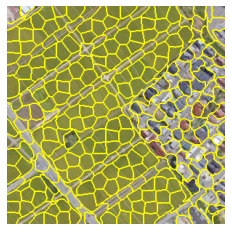

In [7]:
imagen_s1 = io.imread('satelite/p1.png')[:,:,0:3]
s1_superpixel = slic(imagen_s1, n_segments=300, start_label=1, compactness=12.0, sigma=3.0)
plt.imshow(mark_boundaries(imagen_s1, s1_superpixel))
plt.axis('off')
plt.show()
pltI.imsave('satelite/sp1_n300_c12_s3_'+str(np.amax(s1_superpixel))+'.png', mark_boundaries(imagen_s1, s1_superpixel))

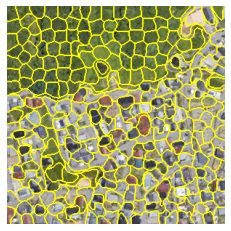

In [8]:
imagen_s2 = io.imread('satelite/p2.png')[:,:,0:3]
s2_superpixel = slic(imagen_s2, n_segments=300, start_label=1, compactness=12.0, sigma=3.0)
plt.imshow(mark_boundaries(imagen_s2, s2_superpixel))
plt.axis('off')
plt.show()
pltI.imsave('satelite/sp2_n300_c12_s3_'+str(np.amax(s2_superpixel))+'.png', mark_boundaries(imagen_s2, s2_superpixel))

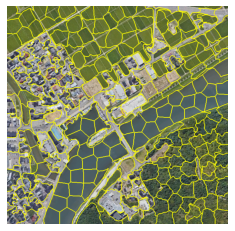

In [9]:
imagen_s3 = io.imread('satelite/p3.png')[:,:,0:3]
s3_superpixel = slic(imagen_s3, n_segments=300, start_label=1, compactness=12.0, sigma=3.0)
plt.imshow(mark_boundaries(imagen_s3, s3_superpixel))
plt.axis('off')
plt.show()
pltI.imsave('satelite/sp3_n300_c12_s3_'+str(np.amax(s3_superpixel))+'.png', mark_boundaries(imagen_s3, s3_superpixel))

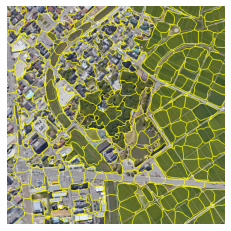

In [10]:
imagen_s4 = io.imread('satelite/p4.png')[:,:,0:3]
s4_superpixel = slic(imagen_s4, n_segments=300, start_label=1, compactness=12.0, sigma=3.0)
plt.imshow(mark_boundaries(imagen_s4, s4_superpixel))
plt.axis('off')
plt.show()
pltI.imsave('satelite/sp4_n300_c12_s3_'+str(np.amax(s4_superpixel))+'.png', mark_boundaries(imagen_s4, s4_superpixel))

Vectores

In [11]:
vectoresC = np.concatenate((sp_glcms(imagen_s1, s1_superpixel), sp_glcms(imagen_s2, s2_superpixel), sp_glcms(imagen_s3, s3_superpixel)))

***

### Clasificación con kmeans
#### Entrenamiento

In [12]:
modelo_kmeans = KMeans(n_clusters=3).fit(vectoresC)

#### Pruebas

In [13]:
clasiKmeans = modelo_kmeans.predict(sp_glcms(imagen_s4, s4_superpixel))
clasiKmeans, clasiKmeans.shape

(array([2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0,
        0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2,
        0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0,
        2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2,
        2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2,
        2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0,
        2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2,
        0, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0,
        0, 2, 2, 2]),
 (268,))

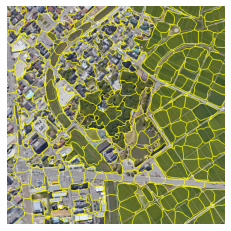

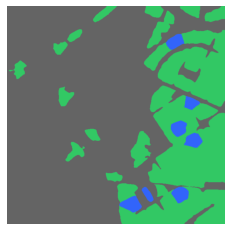

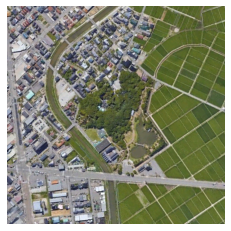

In [14]:
colores_kmeans = [[50,200,100],[50,100,250],[100,100,100],[10,150,250]]
plt.imshow(mark_boundaries(imagen_s4, s4_superpixel))
plt.axis('off')
plt.show()
mostrarSP(s4_superpixel, clasiKmeans, colores_kmeans, imagen_s4, 'Kmeans')
plt.imshow(imagen_s4)
plt.axis('off')
plt.show()

***

### Clasificación con knn
#### Entrenamiento

In [15]:
def spLabeler(imagen, marker, label_n, c_label):
    pixel_aux = [0,0,0]
    pixel_aux0 = [0,0,0]
    pixel_aux1 = [0,0,0]
    pixel_aux2 = [0,0,0]
    var_aux = 0
    Y,X,Z = imagen.shape
    for i in range(Y):
        for j in range(X):
            if marker[i,j] == label_n:
                pixel_aux0 += c_label[0][i,j]
                pixel_aux1 += c_label[1][i,j]
                pixel_aux2 += c_label[2][i,j]
                pixel_aux += imagen[i,j]
                var_aux += 1
    array_aux = [np.mean(pixel_aux0 // var_aux), np.mean(pixel_aux1 // var_aux), np.mean(pixel_aux2 // var_aux)]
    pixel_aux //= var_aux
    #print(array_aux)
    return (1 if(pixel_aux[1]-pixel_aux[2]>30)else(2 if(pixel_aux[2]-pixel_aux[1]>10)else 0))
#    return array_aux.index(max(array_aux))

def labeler(imagen, marker, c_labels):
    superpixel_aux = []
    for nSP in np.unique(marker):
        superpixel_aux.append(spLabeler(imagen, marker, nSP, c_labels))
    return np.array(superpixel_aux,dtype=int)

def multi_labeler(imagenes, markers, ilabels):
    array_aux = np.array([],dtype=int)
    for x in range(len(imagenes)):
        array_aux = np.concatenate((array_aux,labeler(imagenes[x],markers[x],ilabels[x])),dtype=int)
    return array_aux

In [16]:
iesp1_u = io.imread('satelite/sp1_urban.png')[:,:,0:3]
iesp1_r = io.imread('satelite/sp1_verdesito.png')[:,:,0:3]
iesp1_a = np.zeros(imagen_s1.shape, dtype=int)
iesp2_u = io.imread('satelite/sp2_urban.png')[:,:,0:3]
iesp2_r = io.imread('satelite/sp2_verdesito.png')[:,:,0:3]
iesp2_a = np.zeros(imagen_s2.shape, dtype=int)
iesp3_u = io.imread('satelite/sp3_urban.png')[:,:,0:3]
iesp3_r = io.imread('satelite/sp3_verdesito.png')[:,:,0:3]
iesp3_a = io.imread('satelite/sp3_awa.png')[:,:,0:3]
#iesp1_u.shape, iesp1_r.shape, iesp1_a.shape, imagen_s1.shape, iesp2_u.shape, iesp2_r.shape, iesp2_a.shape, imagen_s2.shape, iesp3_u.shape, iesp3_r.shape, iesp3_a.shape, imagen_s3.shape

In [17]:
knn_labels = multi_labeler([imagen_s1,imagen_s2,imagen_s3], [s1_superpixel,s2_superpixel,s3_superpixel], [[iesp1_u,iesp1_r,iesp1_a],[iesp2_u,iesp2_r,iesp2_a],[iesp3_u,iesp3_r,iesp3_a]])

In [19]:
model = KNeighborsClassifier()
model.fit(vectoresC,knn_labels)

KNeighborsClassifier()

#### Pruebas

In [20]:
clasiKNN = model.predict(sp_glcms(imagen_s4, s4_superpixel))

In [21]:
clasiKNN

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0])

In [22]:
colores_knn = [[100,100,100],[148,146,66],[70,100,200]]

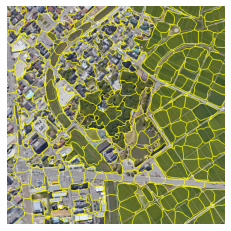

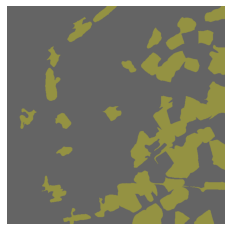

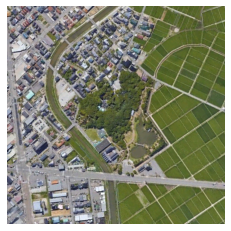

In [23]:
plt.imshow(mark_boundaries(imagen_s4, s4_superpixel))
plt.axis('off')
plt.show()
mostrarSP(s4_superpixel, clasiKNN, colores_knn, imagen_s4, 'KNN')
plt.imshow(imagen_s4)
plt.axis('off')
plt.show()



### Referencias:

- Rosebrock, A. (28 de julio, 2014) A slic superpixel tutorial using python. pyImageSearch. Consultado en https://www.pyimagesearch.com/2014/07/28/a-slic-superpixel-tutorial-using-python/

- Rosebrock, A. (29 de diciembre, 2014) Accessing individual superpixel segmentations python. Consultado en https://www.pyimagesearch.com/2014/12/29/accessing-individual-superpixel-segmentations-python/

- (s.a) (s.f) matplotlib.pyplot.plot Documentacion de Mat-plotlib. Consultado de https://matplotlib.org/stable/api/as7gen/matplotlib.pyplot.plot.html

- (s.a) (s.f) matplotlib.contour.QuadContourSet Documentacion de Matplotlib. Consultado de https://matplotlib.org/stable/api/contourapi.html#matplotlib.contour.QuadContourSet

- (s.a) (s.f) matplotlib.image.AxesImage Documentacion de Matplotlib. Consultado de https://matplotlib.org/stable/api/imageapi.html#matplotlib.image.AxesImage

- (s.a) (s.f) matplotlib.pyplot.imshow Documentacion de Matplotlib. Consultado de https://matplotlib.org/stable/api/asgen/matplotlib.pyplot.imshow.html

- (s.a) (s.f) matplotlib.patches.Patch. Documentacion de Matplotlib. Consultado de https://matplotlib.org/stable/api/asgen/matplotlib.patches.Patch.html

- (s.a) (s.f) Shapely and geometric objects. Consultado de https://automating-gisprocesses.github.io/site/notebooks/L1/geometric-objects.html

- (s.a) (s.f) matplotlib.path. Documentacion de Matplotlib. Consultado de https://matplotlib.org/stable/api/pathapi.html

- (s.a) (s.f) matplotlib.pyplot.plot. Documentacion de Matplotlib. Consultado de https://matplotlib.org/stable/api/asgen/matplotlib.pyplot.plot.html

- (s.a) (s.f) Image Resolution and DPI. Consultado de https://largeprinting.com/resources/image-resolution-anddpi.html

- (s.a)(26 de dic, 2020) Apply a Gauss filter to an image with Python. Geeks for Geeks. Consultado de https://www.geeksforgeeks.org/apply-a-gauss-filter-to-animage-with-python/

- (s.a) (14 de julio, 2019) Python PIL GaussianBlur() method. Geeks for Geeks. Consultado
de https://www.geeksforgeeks.org/python-pil-gaussianblurmethod/

- Banterla, D. (s/f) Texturas. Fac. Informatica San Sebastian. Consultado de http://www.ehu.eus/ccwintco/uploads/d/d7/Texturas.pdf

- Dabbura, I. (17 de spetiembre, 2018) K-means Clustering: Algorithm, Applications, Evaluation Methods,and Drawbacks. Towards data science. Consultado de https://towardsdatascience.com/k-means-clusteringalgorithm-applications-evaluation-methods-and-drawbacksaa03e644b48a

- gene (13 de abril, 2017) Geopandas Polygon to matplotlib patches Polygon conversion Stack Exchange. Consultado de https://gis.stackexchange.com/questions/197945/geopandaspolygon-to-matplotlib-patches-polygon-conversion

- gene (4 de junio, 2014). Converting Matplotlib contour objects to Shapely objects. Stack Overflow. Consultado de https://gis.stackexchange.com/questions/99917/convertingmatplotlib-contour-objects-to-shapely-objects

- Ghandi, R. (5 de Mayo, 2018) Naive Bayes Classifier Towards Data Science. Consultado de https://towardsdatascience.com/naive-bayes-classifier81d512f50a7c

- Gillies, S.(27 de sep, 2020) The Shapely User Manual. Shapely. Consultado de https://shapely.readthedocs.io/en/stable/manual.html

- Hall-Beyer, M. (2017) GLCM Texture: A Tutorial v. 3.0. University of Calgary. Consultado de https://prism.ucalgary.ca/bitstream/handle/1880/51900/texture%20tutorial%20v%2030%20180206.pdf?sequence=11&isAllowed=y

- jodag. (6 de mayo, 2020) Matplotlib -unable to save image in same resolution as original image. Stack Overflow. Consultado de https://stackoverflow.com/questions/34768717/matplotlibunable-to-save-image-in-same-resolution-as-originalimage34769840

- Korstanje, J. (7 de abril, 2021) The k-Nearest Neighbors (kNN) Algorithm in Python. RealPython. Consultado en https://realpython.com/knn-python/

- Lin, W. et al. (2010) Image Segmentation Using the Kmeans Algorithm for Texture Features. World Academy of Science, Engineering and Technology International Journal of Computer and Information Engineering

- Navlani, A. (2 de agosto, 2018) KNN Classification using Scikit-learn. Datacamp. Consultado en https://www.datacamp.com/community/tutorials/k-nearestneighbor-classification-scikit-learn

- R, Kirsten et al. (5 se septiembre, 2019) Performance of two multiscale texture algorithms in classifying silver gelatine paper via k-nearest neighbors. Open Archive Toulouse Archive Ouverte. Consultado de https://hal.archives-ouvertes.fr/hal02279362/document

- Rosebrock, A. (8 de agosto, 2016) k-NN classifier for image classification. pyImageSearch. Consultado en https://www.pyimagesearch.com/2016/08/08/k-nn-classifierfor-image-classification/

- tom10 (23 de Marzo, 2015) Python - convert contours to image. Stack Overflow. Consultado de https://stackoverflow.com/questions/29213238/pythonconvert-contours-to-image2921417

- A. Rosebrock, "k-NN classifier for image classification - PyImageSearch", PyImageSearch, 2021. [Online]. Available: https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/. [Accessed: 26- Jul- 2021].

- scikit-learn, "sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.24.2 documentation", Scikit-learn.org. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit. [Accessed: 26- Jul- 2021].

- scikit-image, "Module: segmentation — skimage v0.19.0.dev0 docs", Scikit-image.org, 2021. [Online]. Available: https://scikit-image.org/docs/dev/api/skimage.segmentation.html. [Accessed: 29- Jul- 2021].

- scikit-learn, "sklearn.cluster.KMeans — scikit-learn 0.24.2 documentation", Scikit-learn.org, 2021. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html. [Accessed: 29- Jul- 2021].